Dataset with students data extracted from Unir archive.  
Geodataframes extracted from the openlibraries https://datosabiertos.esri.co/ and https://sites.google.com/site/seriescol/shapes  
The file 'geodata.shp' was generated from previous chapter.  
Homicide: Data from https://es.wikipedia.org/wiki/Anexo:Departamentos_y_municipios_de_Colombia_por_tasa_de_homicidio_intencional  
Cocain: Data from http://www.odc.gov.co/sidco/oferta/cultivos-ilicitos/departamento-municipio

# Libraries and datasets loading

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Default plot size is set.
plt.rcParams['figure.figsize'] = [15, 15]

# Avoid pandas copy warnings
pd.options.mode.chained_assignment = None

# Geodataframe and dataset are loaded.
geodata = gpd.read_file('geodata-withsocial.gpkg')
gdf_dep = gpd.read_file('depto.shp')

In [2]:
# Create a column "centroids" with the centroid information of each shape
geodata['centroids'] = geodata['geometry'].centroid
geodata['area'] = geodata['geometry'].area

# Create a separate array "coords" with this information, for space syntax analysis
coords = np.array(list((x,y) for x,y in zip(geodata['centroids'].x , geodata['centroids'].y)))
areas = np.array(list(geodata['area']))

geodata.head()

DPTO              DEPARTAMENTO          AREA    PERIMETER      HECTARES  \
0   91                  AMAZONAS  1.100294e+11  2562641.642  1.100294e+07   
1   95                  GUAVIARE  5.567148e+10  1555059.349  5.567148e+06   
2   85                  CASANARE  4.471409e+10  1101844.910  4.471409e+06   
3   27                     CHOCO  4.683852e+10  1797897.873  4.683852e+06   
4   88  SAN ANDRES Y PROVIDENCIA  4.960252e+07    71946.251  4.960252e+03   

   Cases_Frequency  Cases_Order_Value        NUMERO   ESTRATO       EDAD  ...  \
0                1                  0  12080.000000  2.000000  41.000000  ...   
1                2                  1   7904.500000  4.000000  24.000000  ...   
2                3                  2   8900.000000  2.666667  27.666667  ...   
3                6                  3  11630.500000  2.000000  38.166667  ...   
4                7                  4  12222.714286  2.285714  31.714286  ...   

   viviendas con personas presentes  viviendas   hogares  poblacion  \
0                           15422.0    16911.0   16290.0    66056.0   
1                           22146.0    28659.0   22817.0    73081.0   
2                          120179.0   148783.0  128130.0   379892.0   
3                          128125.0   154778.0  133687.0   457412.0   
4                           16197.0    18410.0   16354.0    48299.0   

   numero homicidios 2016  tasa homicidios 2016  coca (hectareas)  \
0                      17                 22.05            121.65   
1                      22                 19.53           4339.96   
2                      87                 23.99               NaN   
3                     186                 39.60           2155.13   
4                      12                 15.56               NaN   

                                            geometry  \
0  POLYGON ((1300074.955 504576.022, 1301222.910 ...   
1  POLYGON ((1313267.569 805589.040, 1313847.891 ...   
2  POLYGON ((1432862.966 1183947.874, 1433379.527...   
3  POLYGON ((675910.420 1407355.341, 676737.654 1...   
4  MULTIPOLYGON (((168440.793 1896450.410, 168454...   

                         centroids          area  
0   POINT (1284508.957 318512.696)  1.100294e+11  
1   POINT (1217554.328 701434.247)  5.567148e+10  
2  POINT (1272557.734 1085709.530)  4.471409e+10  
3   POINT (678532.313 1154088.734)  4.683852e+10  
4   POINT (185523.447 1931186.742)  4.960252e+07  

[5 rows x 52 columns]

# 1.- N-Neighbours Space Syntax data:  Morphological Ratio and others

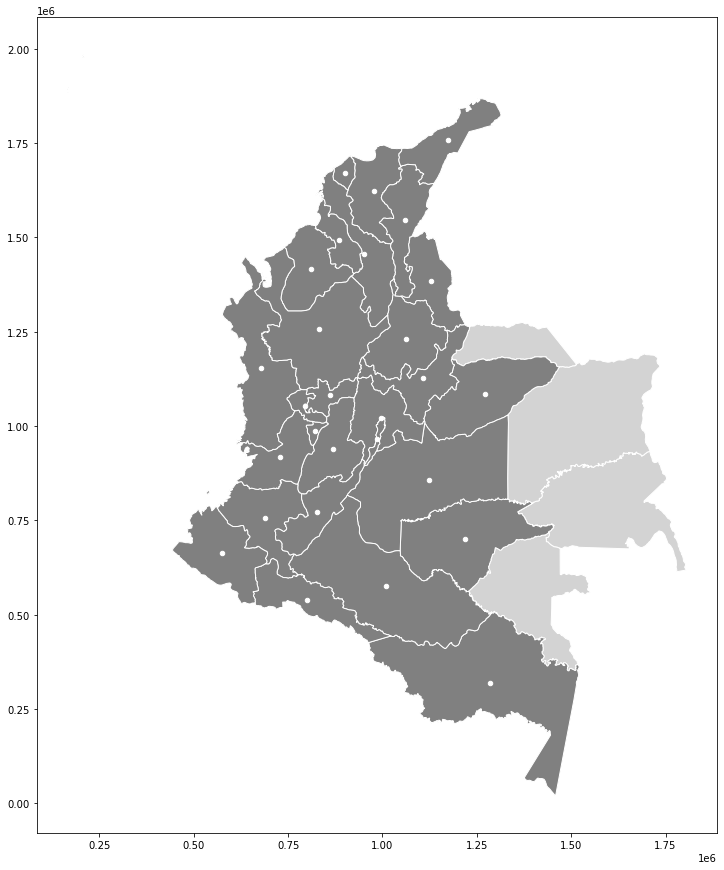

In [3]:
fig, ax = plt.subplots()
gdf_dep.plot(color='lightgrey', edgecolor='white', ax=ax)
geodata.plot(color='grey', edgecolor='white', ax=ax)
ax.scatter(coords[:, 0], coords[:, 1], color='white', s=20)
plt.show()

In [4]:
# Create SpaceSyntax columns

geodata['Closest centroid'] = 0.00
geodata['Morphological Ratio'] = 0.00
geodata['Northing to closest centroid'] = 0.00
geodata['Easting to closest centroid'] = 0.00
geodata['Direction to closest centroid'] = 0.00
geodata['Northing Average to centroids'] = 0.00
geodata['Easting Average to centroid'] = 0.00
geodata['Direction Average to centroid'] = 0.00

In [5]:
# Create morphological_ration function

def morphological_ratio (n, department_index):
    # n = n_neighbours, which minimum is 2 (just the closest one).
    # If n = 3 it means the closest coords are the next 2 closest ones, in proximity order
    X = coords

    nbrs = NearestNeighbors(n_neighbors = n, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # pt is the point to predict
    pt = department_index
    pt_ind = X[indices[pt]]
    
    #----------TEXT OUTPUT----------------------------------------------------------------------

    shape_area = areas[pt]
    proportion_area_dist = distances[pt,1] / (shape_area)**0.5
    text_a = "The department is = " + str(geodata['DEPARTAMENTO'][pt])
    text_b = "The closest centroid distance is = " + str( round((distances[pt,1]), 2)) + " m" 
    text_c = "The shape area is = " + str(round(shape_area,2)) + " m2. Which is = " + str(round((shape_area/1000000),2)) + " km2"
    text_d = "Morphological Ratio (MR) = " + str(round(proportion_area_dist,2))

    # y differences and x differences
    northing = round(pt_ind[1,1]-pt_ind[0,1], 2)
    easting = round(pt_ind[1,0]-pt_ind[0,0], 2)
    text_e = "Northing/Easting to closest centroid = " + str(northing) + " m /" + str(easting) + " m"
 
    if northing > 0:
        f1 = "North"
    else:
        f1 = "South"
    if easting > 0:
        f2 = "East"
    else:
        f2 = "West"
    text_f = "The closest centroid is located = " + f1 + " " + f2
    
    av_northing = 0
    av_easting = 0
    for i in range(n-1):
        av_northing += round(pt_ind[(i+1),1]-pt_ind[0,1], 2)
        av_easting += round(pt_ind[(i+1),0]-pt_ind[0,0], 2)
    av_northing = round(av_northing / (n-1), 2)
    av_easting = round(av_easting / (n-1), 2)
    
    text_g = "Average Northing/Easting to centroids = " + str(av_northing) + " m /" + str(av_easting) + " m"

    if av_northing > 0:
        h1 = "North"
    else:
        h1 = "South"
    if av_easting > 0:
        h2 = "East"
    else:
        h2 = "West"
    text_h = "The average centroids are located = " + h1 + " " + h2
    texts = text_a+"\n"+text_b+"\n"+text_c+"\n"+text_d+"\n"+text_e+"\n"+text_f+"\n"+text_g+"\n"+text_h
    
    #----------PLOTTING----------------------------------------------------------------------
 
    fig, ax = plt.subplots()
    gdf_dep.plot(color='lightgrey', edgecolor='white', ax=ax)
    geodata.plot(color='grey', edgecolor='white', ax=ax)
    ax.scatter(coords[:, 0], coords[:, 1], color='white', s=20)

    for i in range(n-1):
        ax.scatter(pt_ind[(i+1),0], pt_ind[(i+1),1], color='black', s=40, zorder=2)
        ax.plot((pt_ind[0,0],pt_ind[(i+1),0]), (pt_ind[0,1],pt_ind[(i+1),1]), color='black',linewidth=1, zorder=1)

    ax.scatter(pt_ind[0,0], pt_ind[0,1], color='red', s=40, zorder=2)
    ax.scatter(pt_ind[(1),0], pt_ind[(1),1], color='yellow', s=40, zorder=2)

    ax.add_patch(plt.Circle((pt_ind[0,0],pt_ind[0,1]), distances[pt,1], color='yellow', fill=False,linewidth=2))
    ax.plot((pt_ind[0,0],pt_ind[1,0]), (pt_ind[0,1],pt_ind[1,1]), color='yellow',linewidth=2, zorder=1)

    plt.title(str(geodata['DEPARTAMENTO'][pt]) + " - MORPHOLIGICAL RATIO")
    plt.xlabel(texts, ha='left', x = -0.001, fontsize=12)
    plt.savefig("./MorphologicalRatios/" + geodata['DEPARTAMENTO'][pt] + ".jpg")
 
    #----------DATAFRAME UPDATE----------------------------------------------------------------------
    
    geodata['Closest centroid'][pt] = round((distances[pt,1]), 2)
    geodata['Morphological Ratio'][pt] = round(proportion_area_dist,2)
    geodata['Northing to closest centroid'][pt] = northing
    geodata['Easting to closest centroid'][pt] = easting
    geodata['Direction to closest centroid'][pt] = f1 + " " + f2
    geodata['Northing Average to centroids'][pt] = av_northing
    geodata['Easting Average to centroid'][pt] = av_easting
    geodata['Direction Average to centroid'][pt] = h1 + " " + h2

<ipython-input-5-e915ada301d5>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


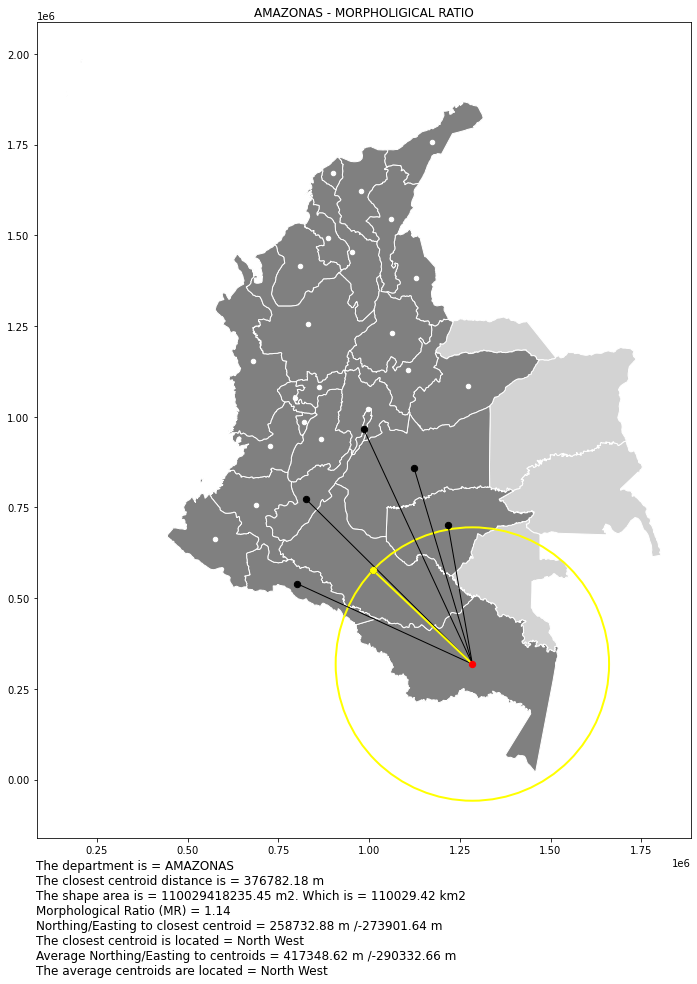

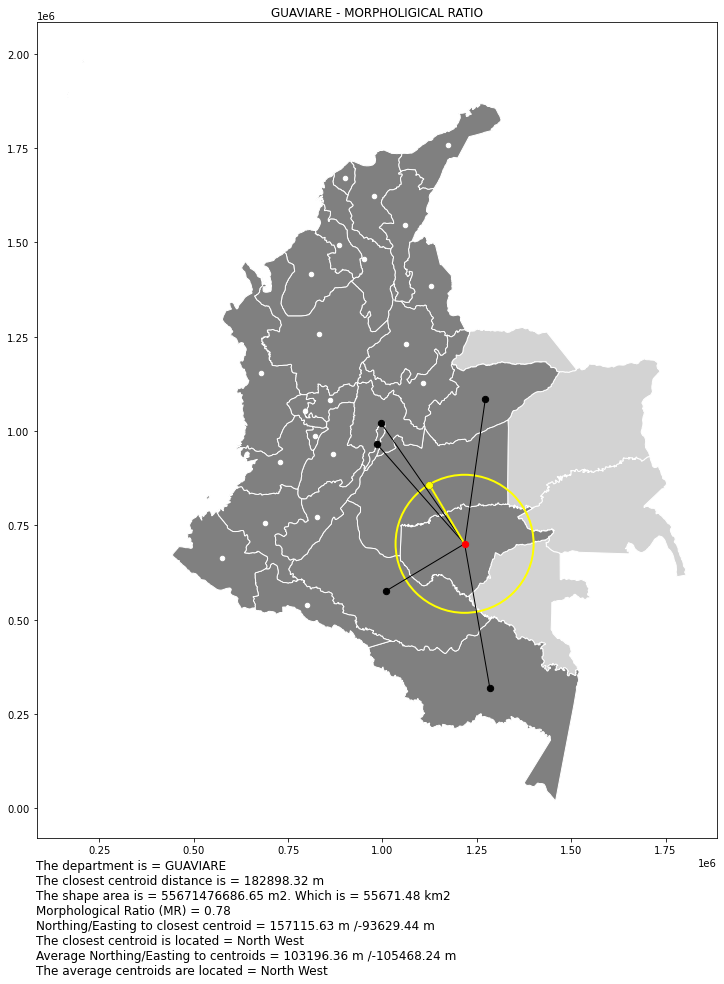

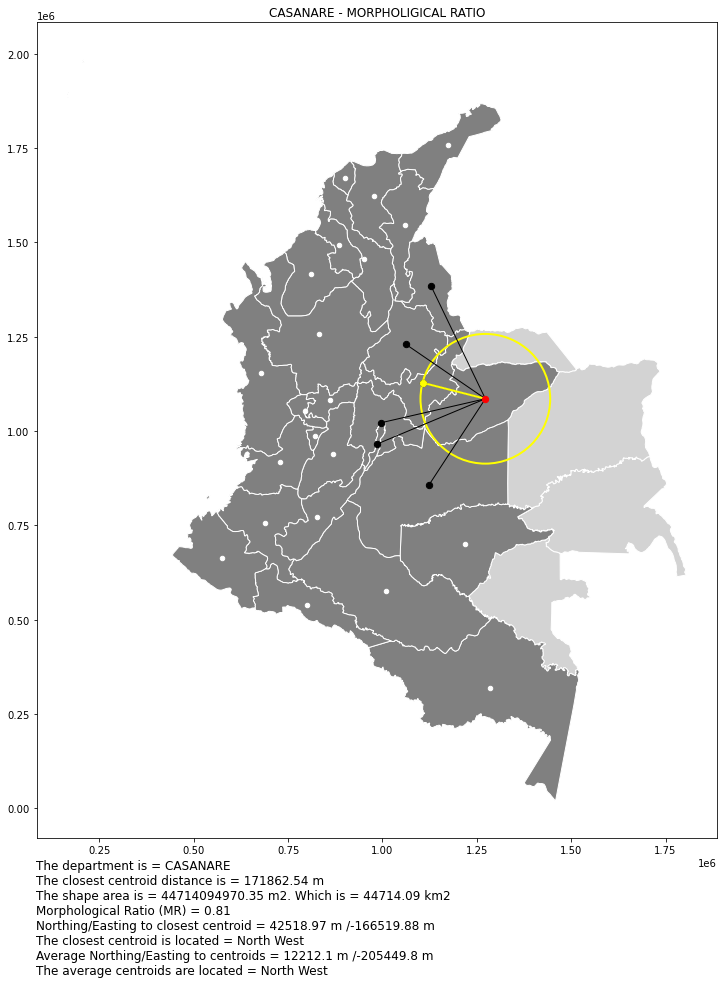

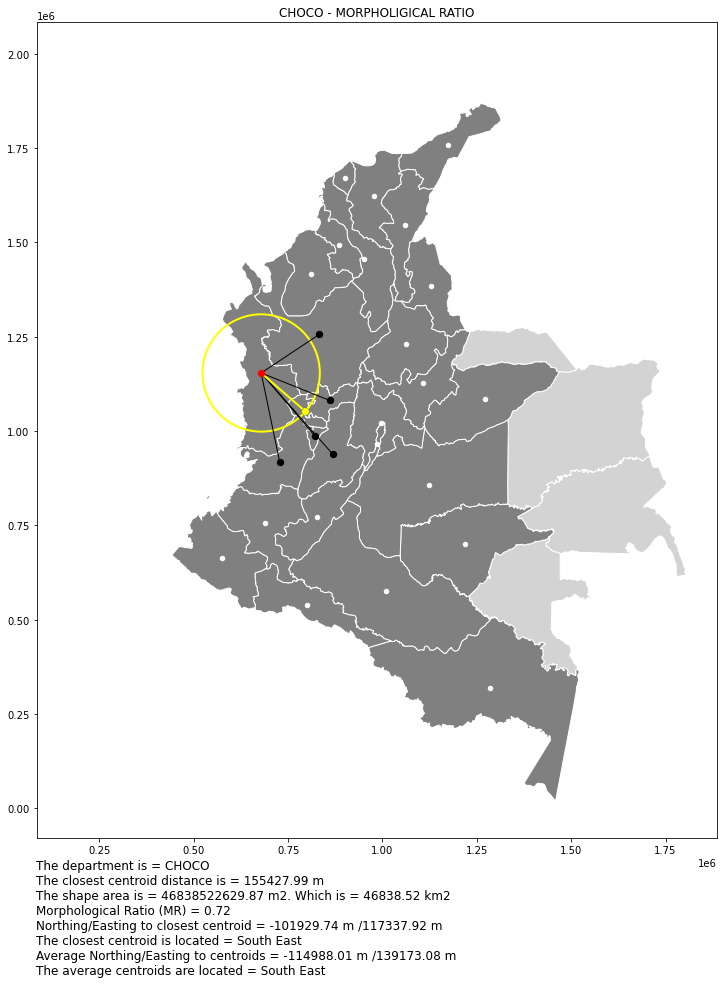

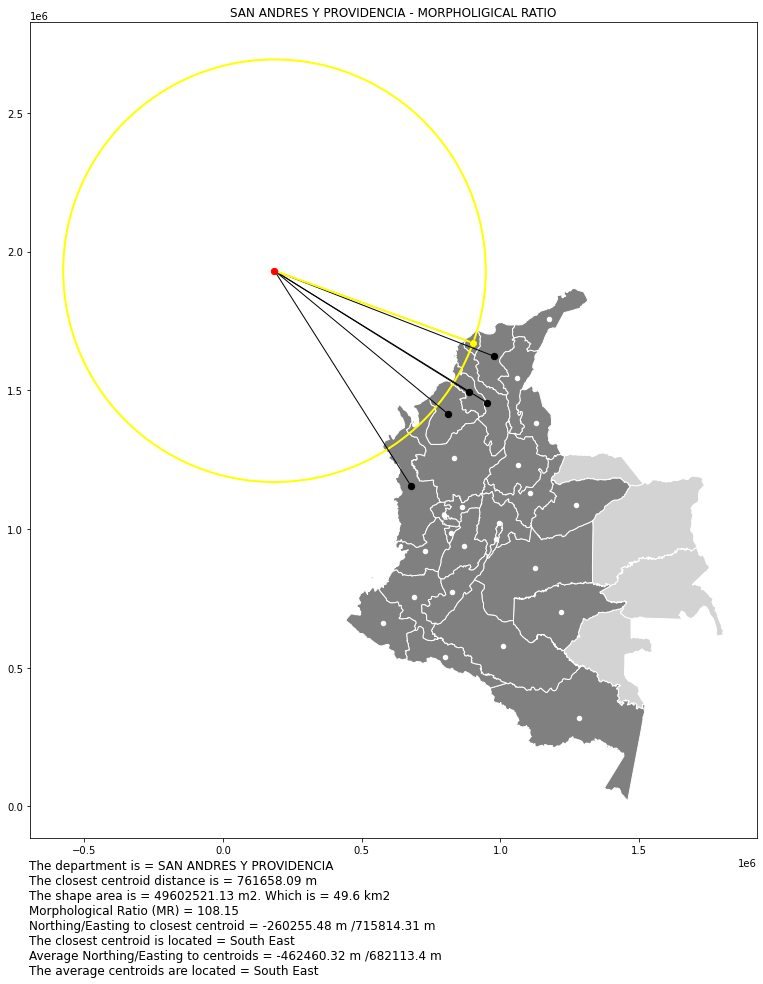

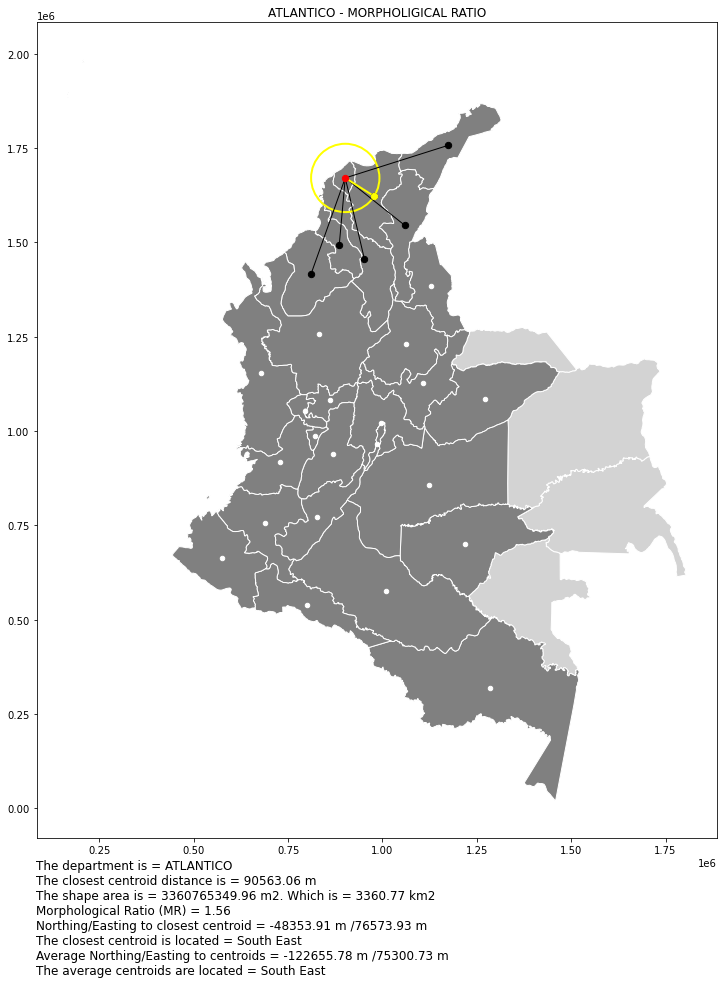

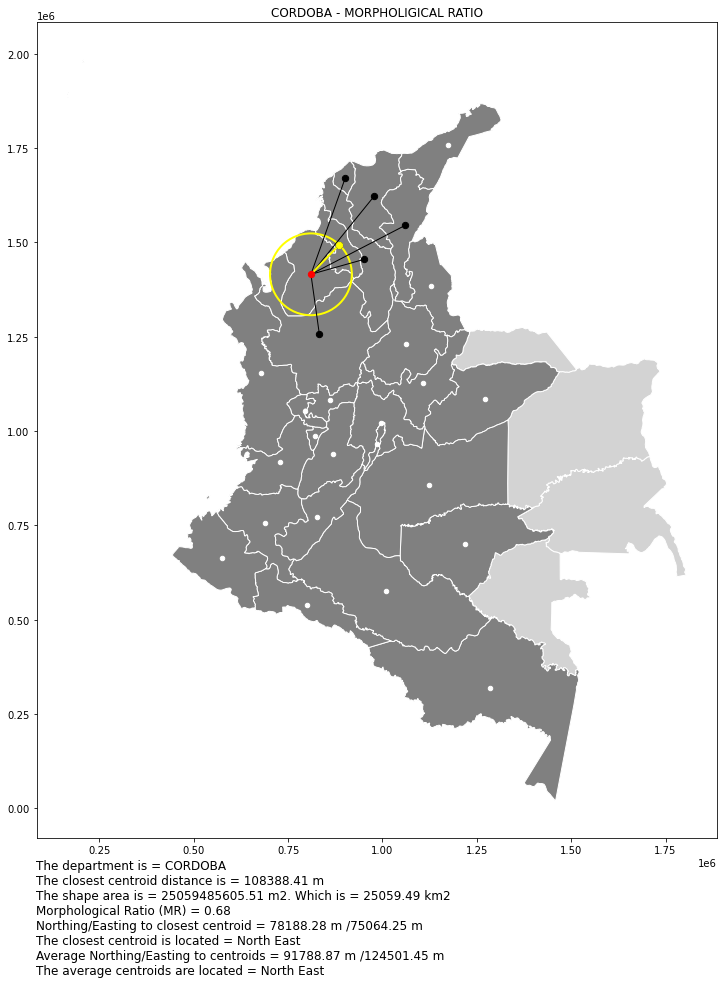

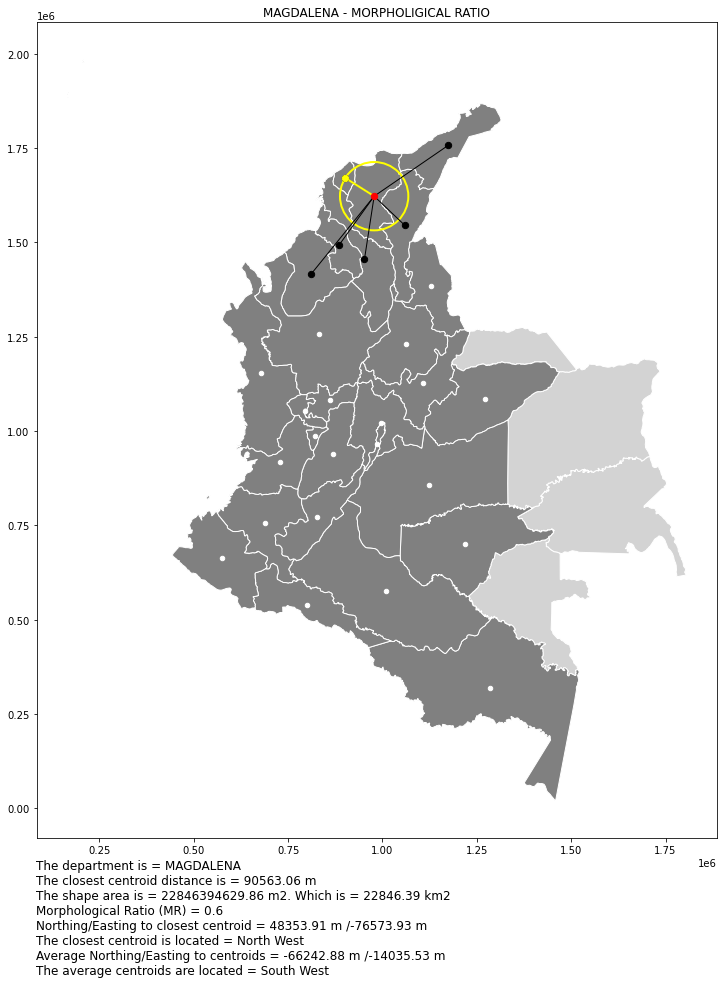

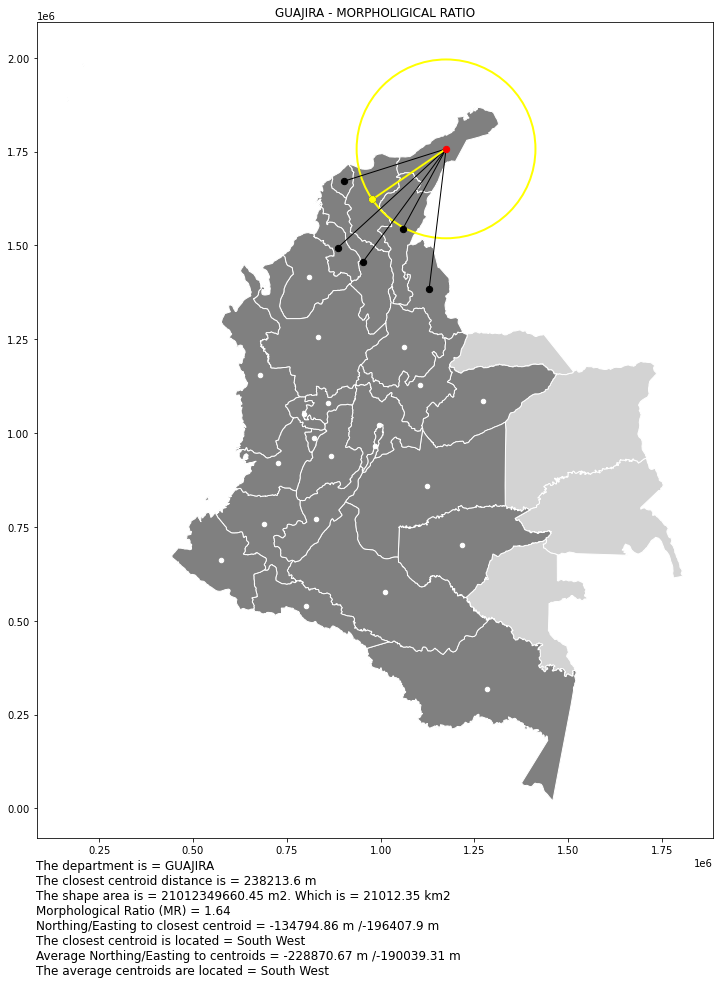

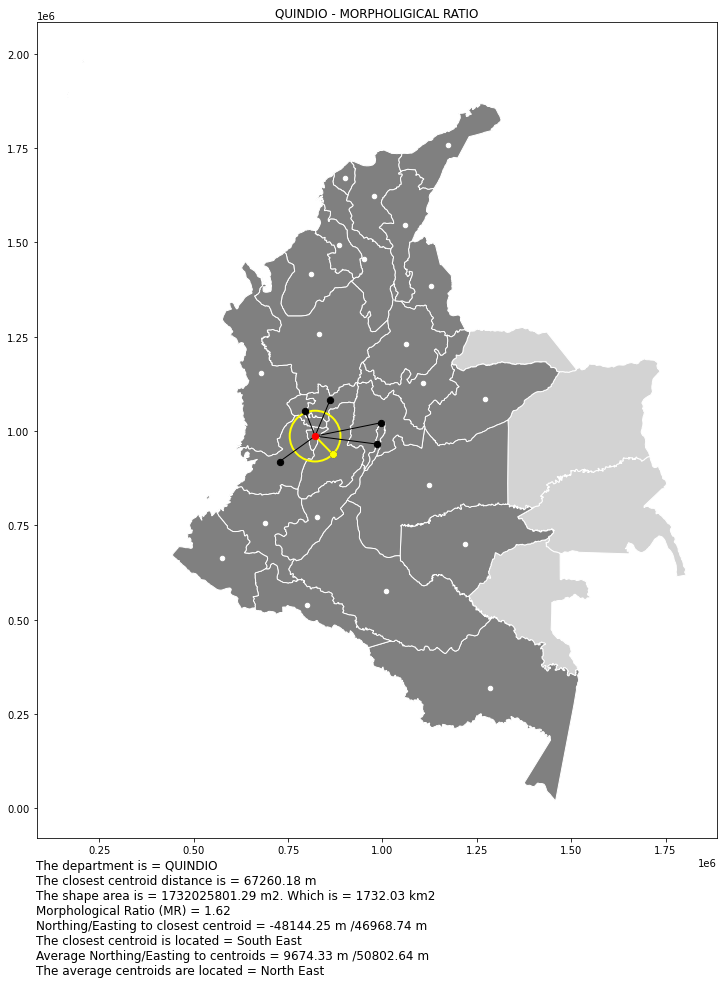

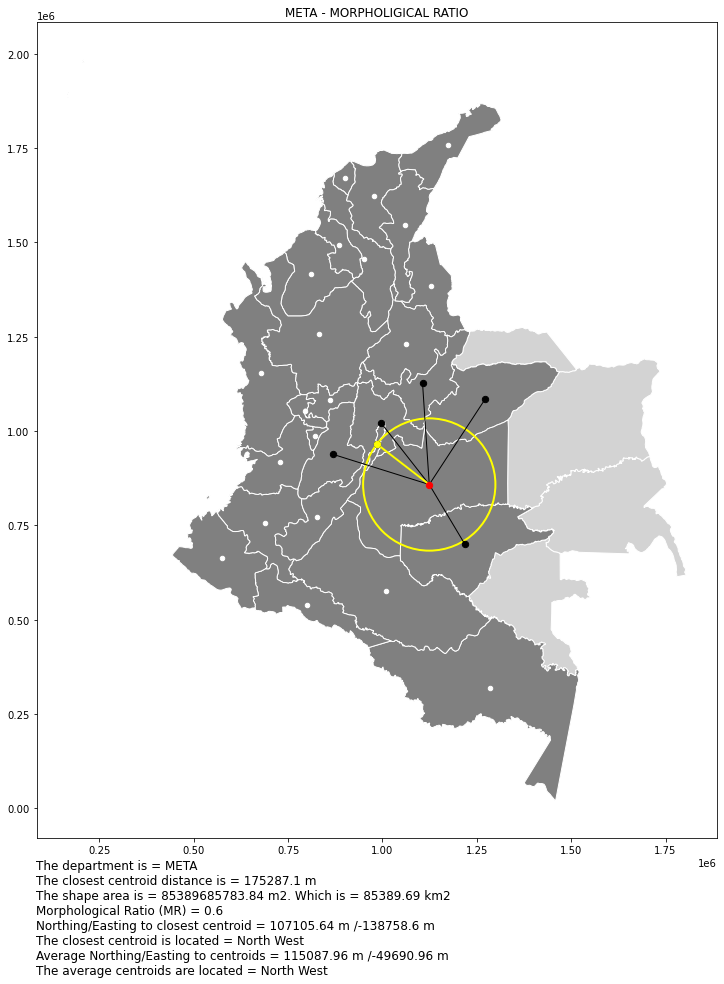

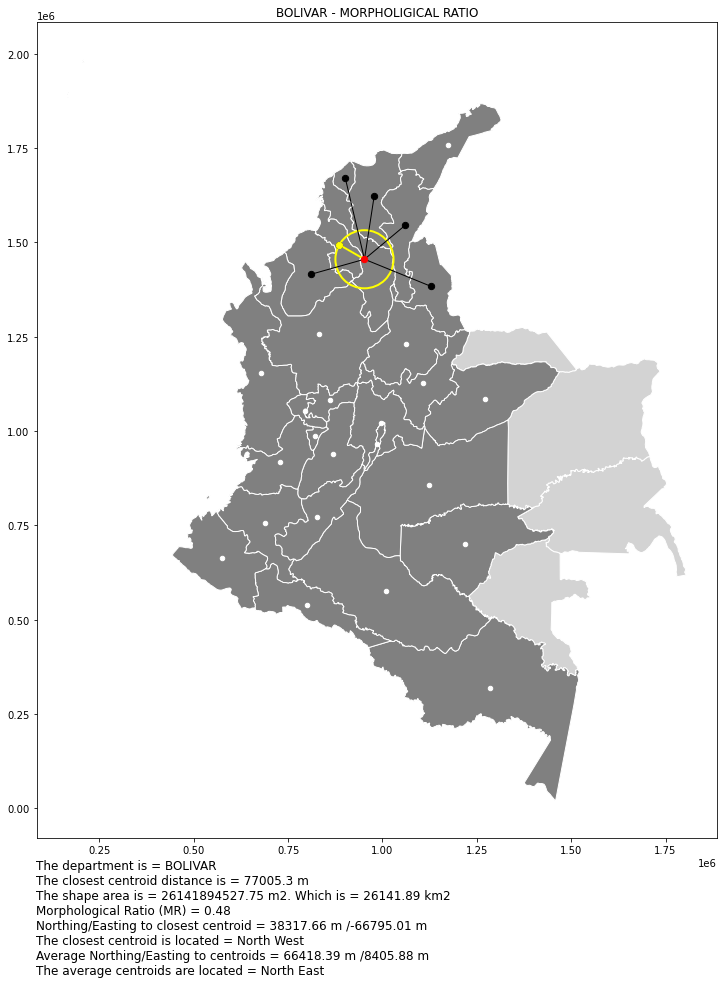

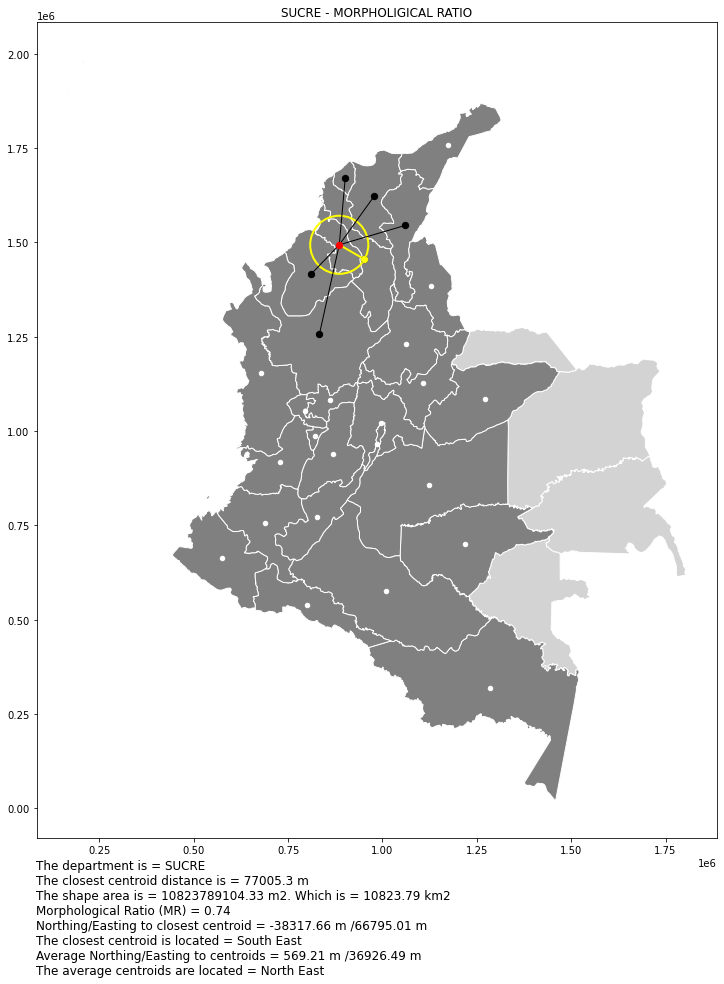

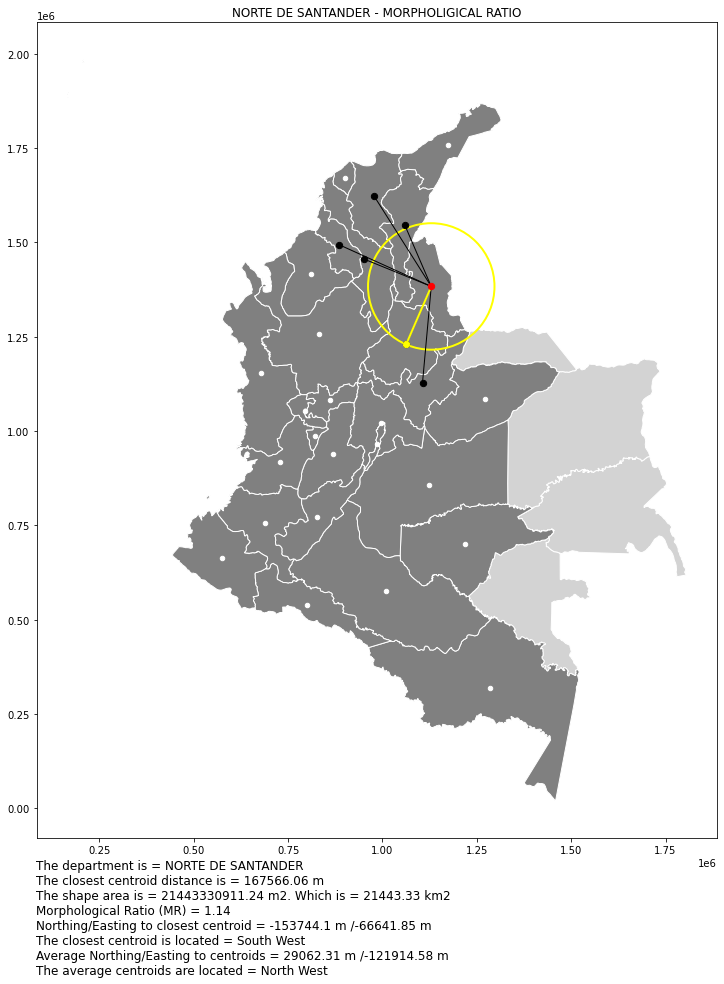

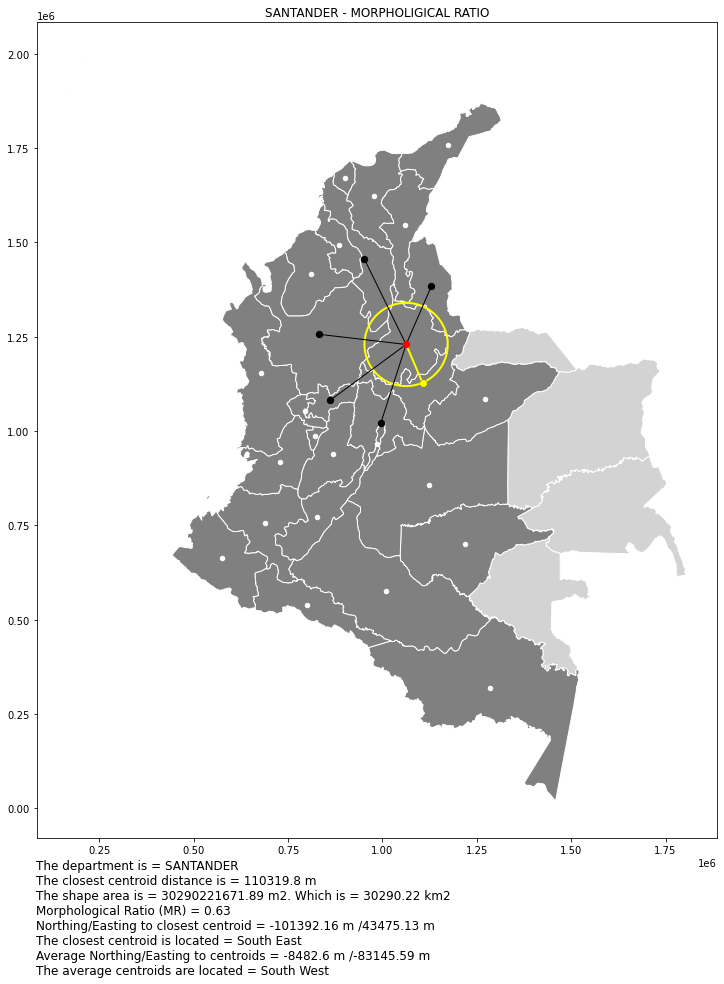

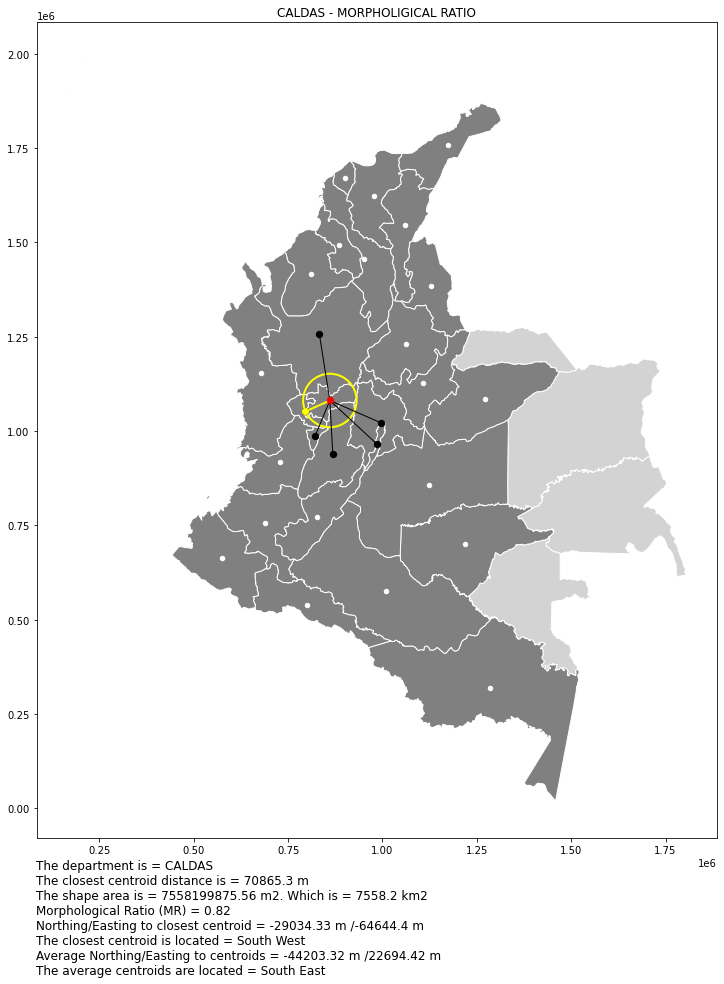

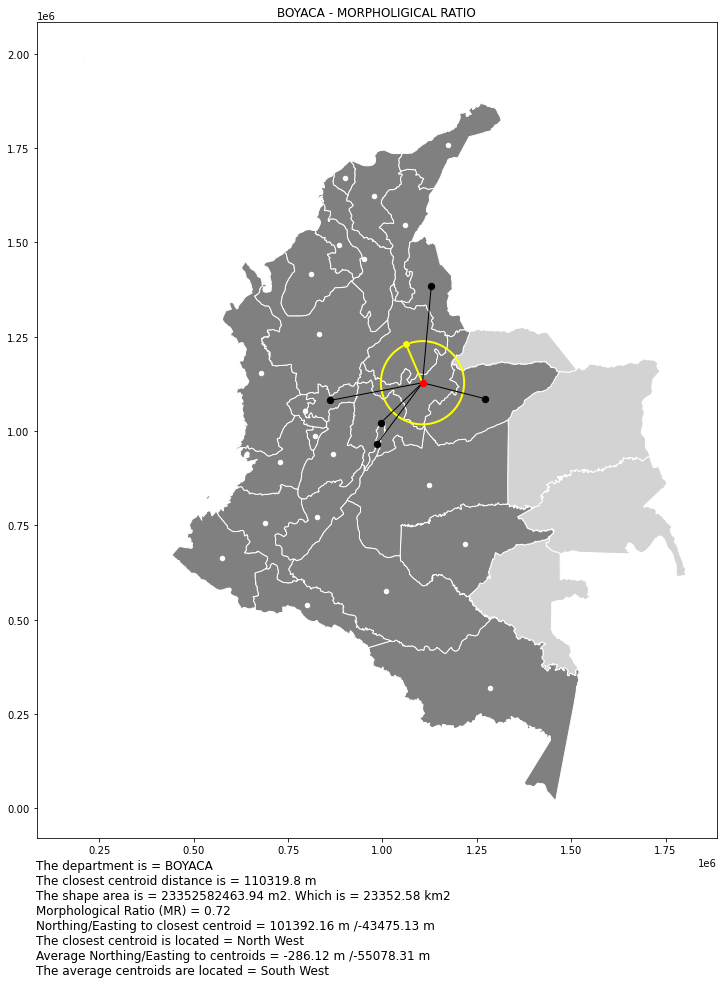

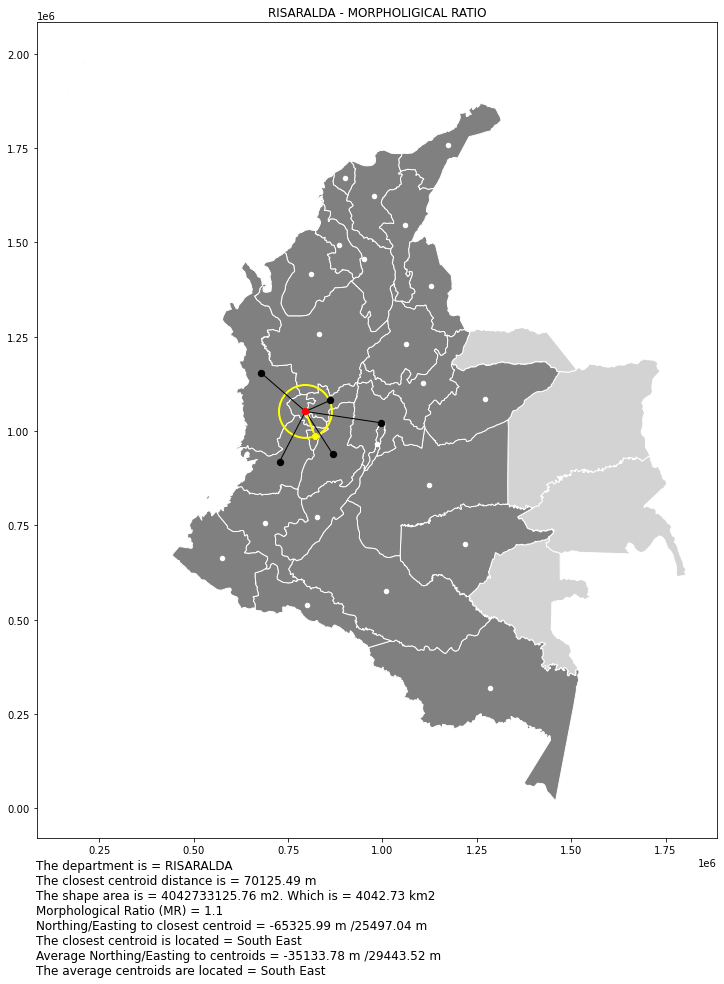

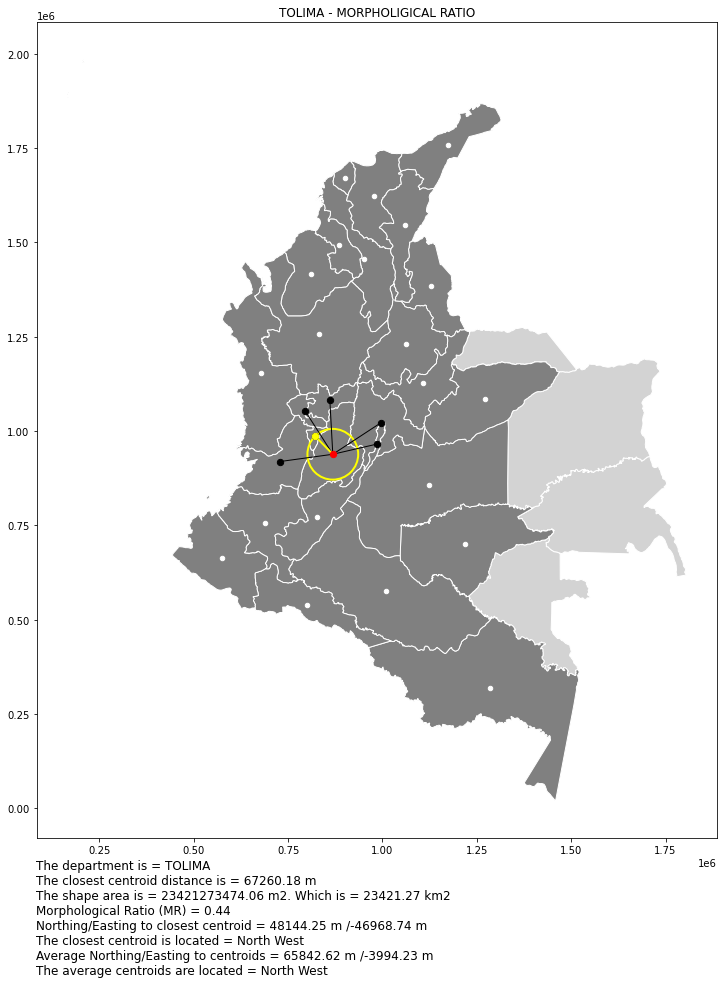

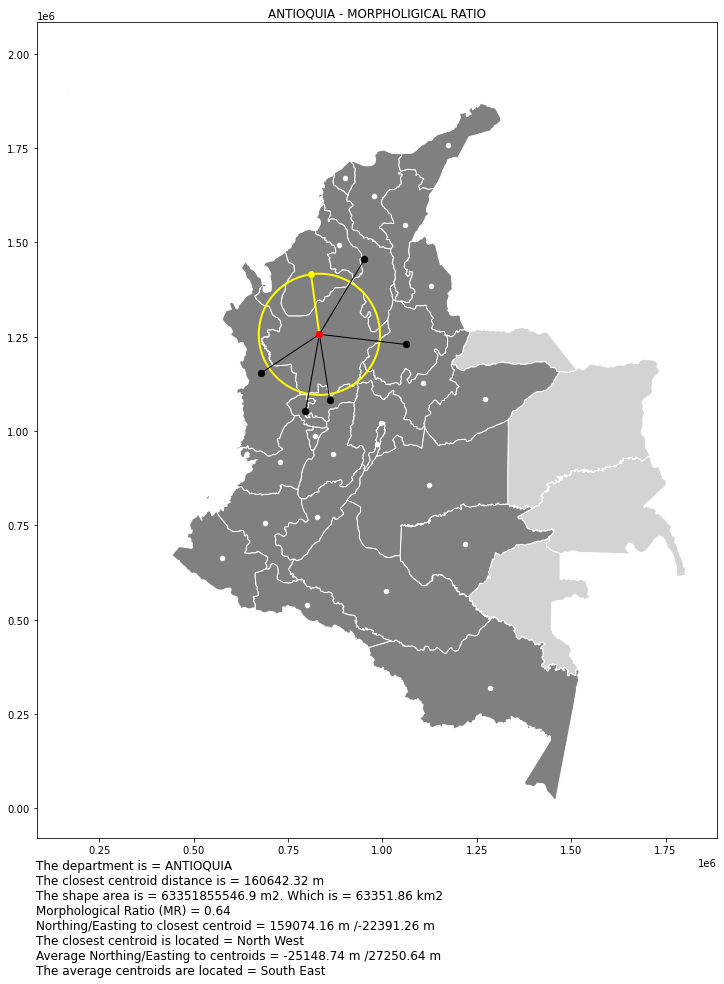

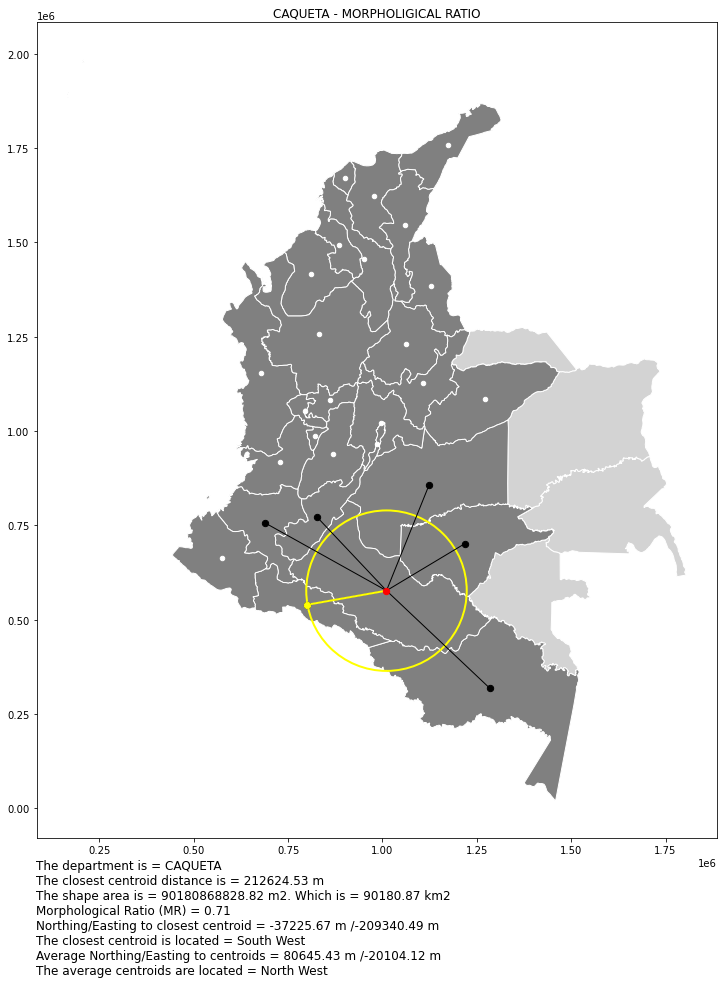

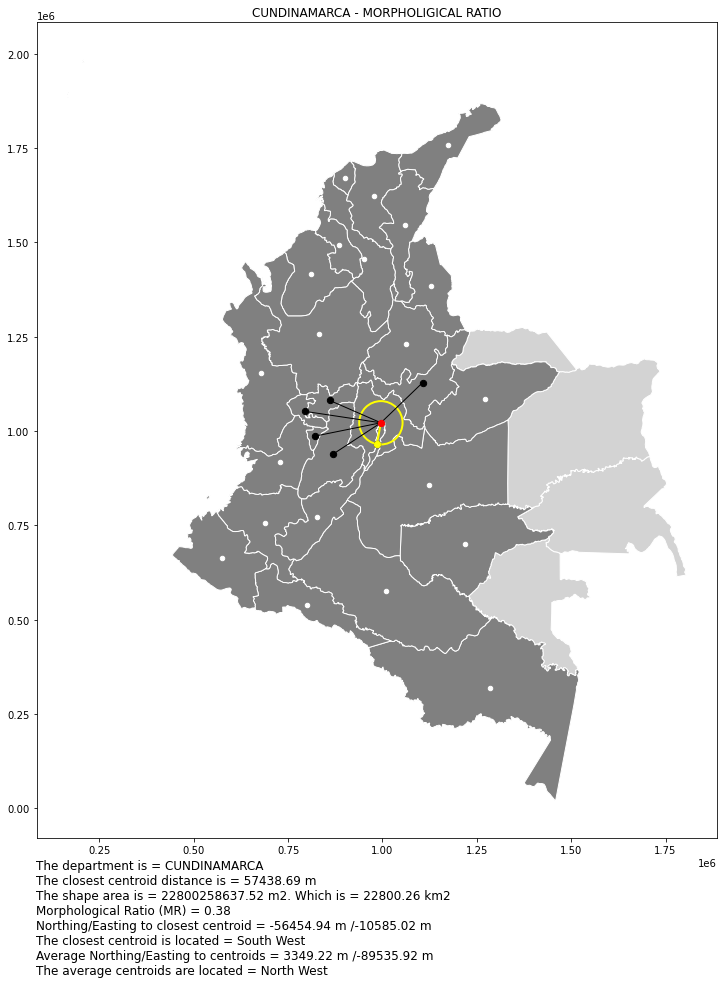

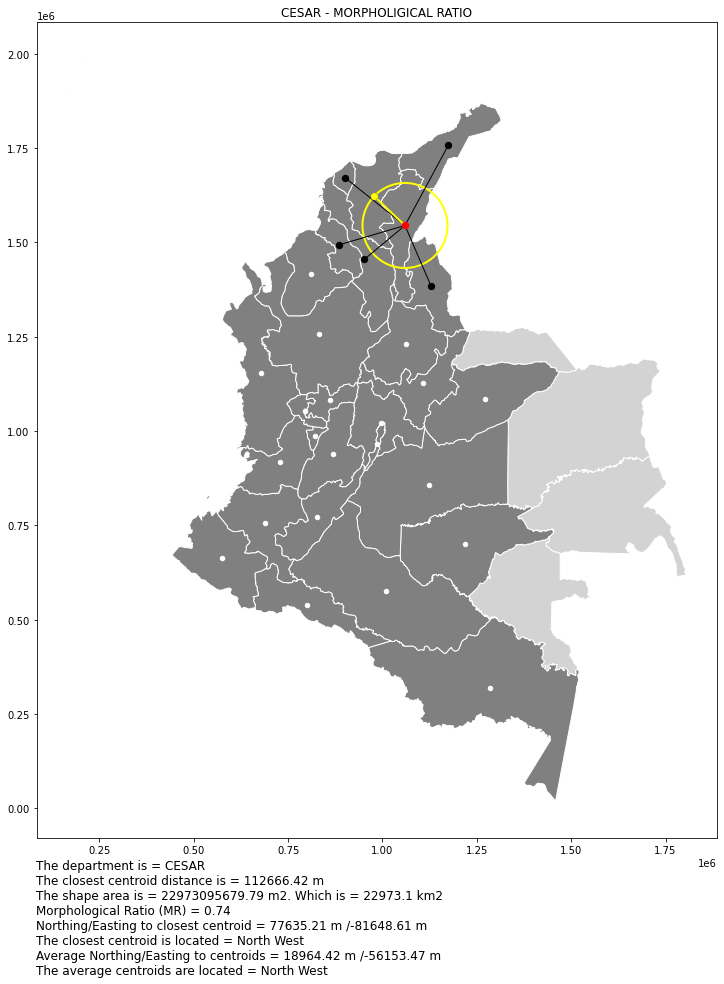

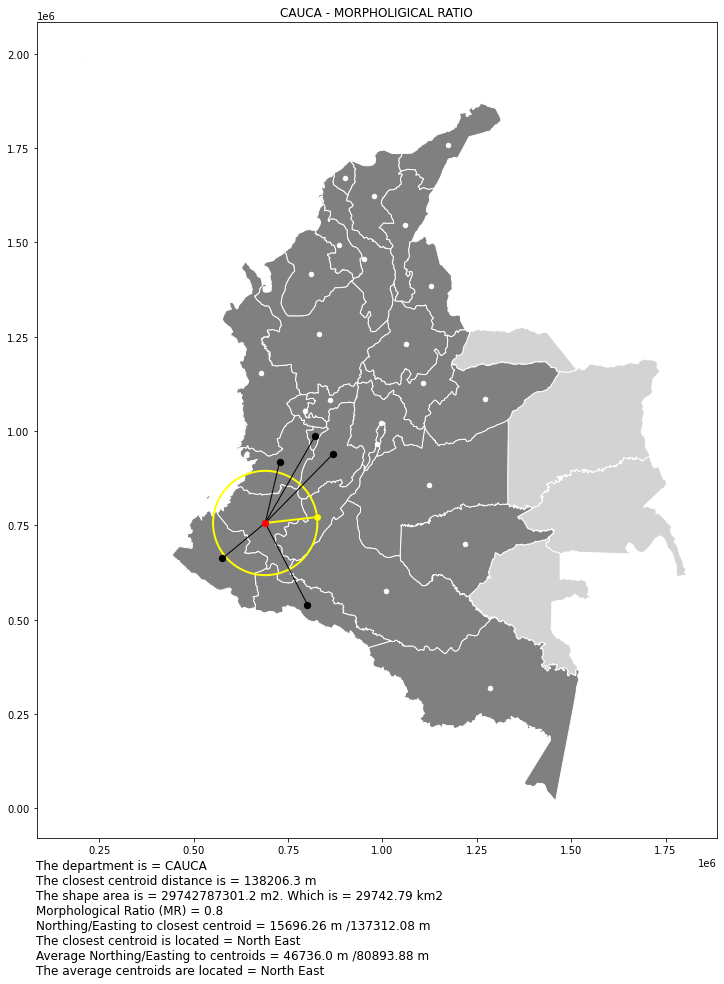

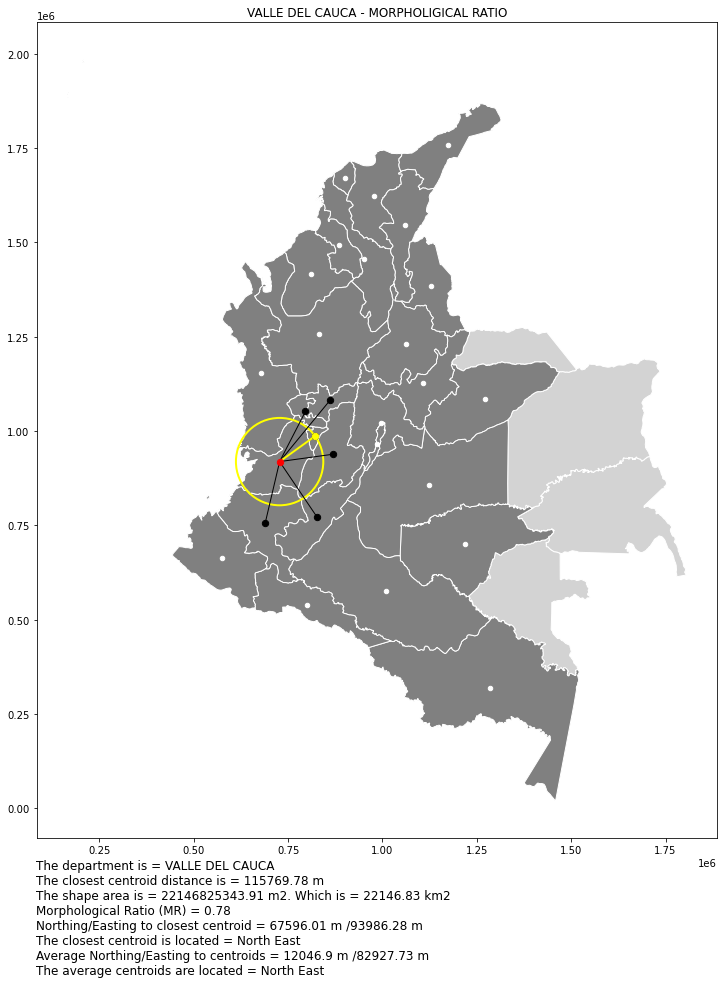

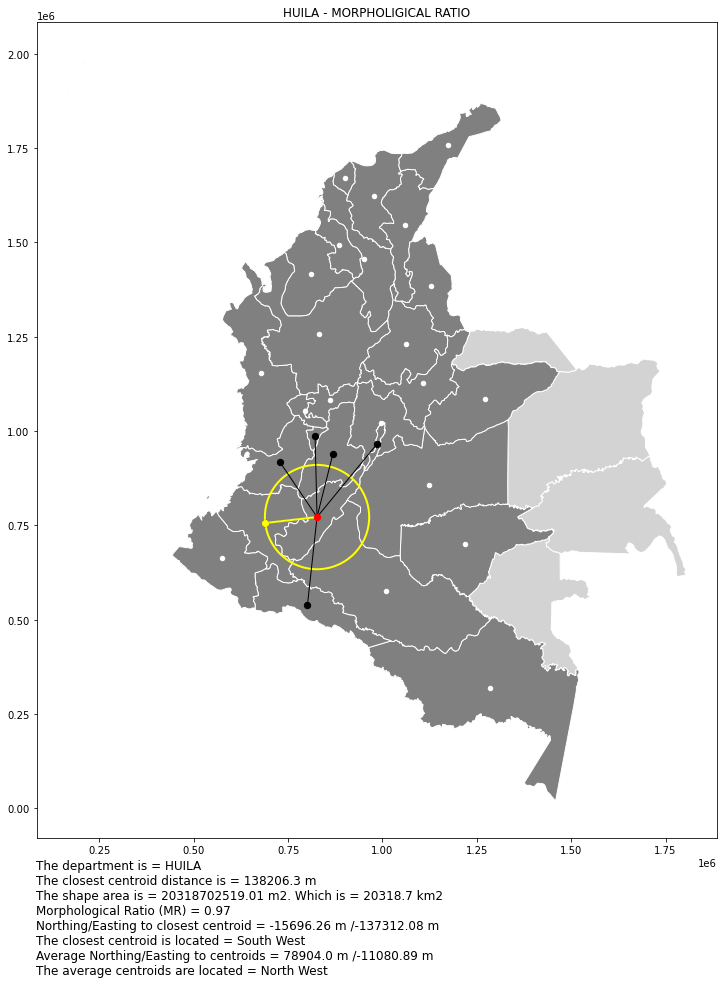

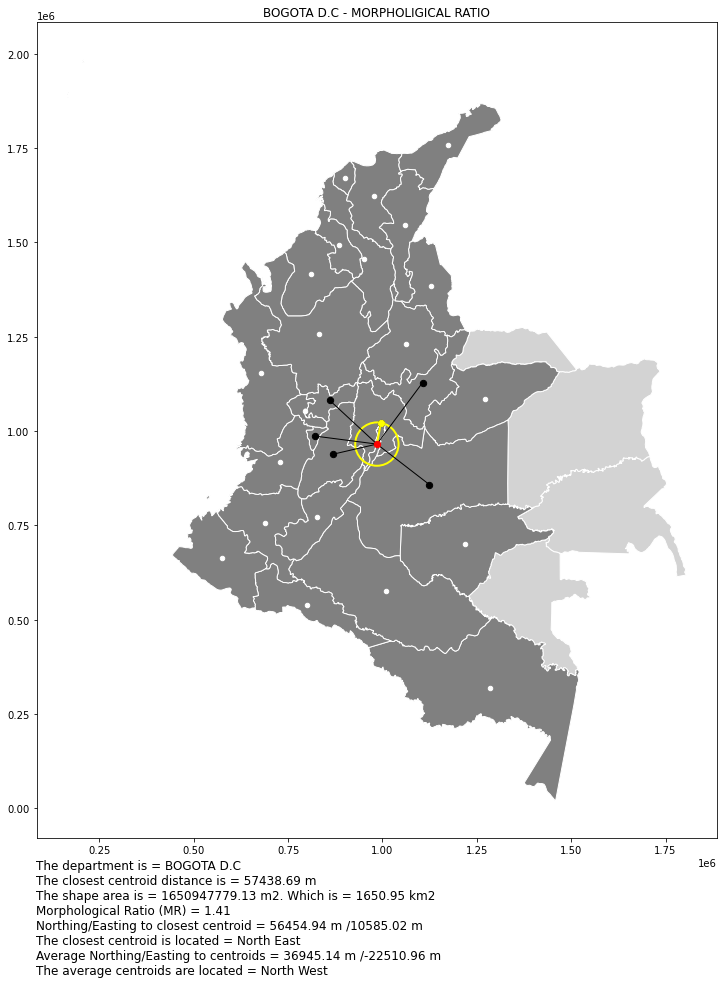

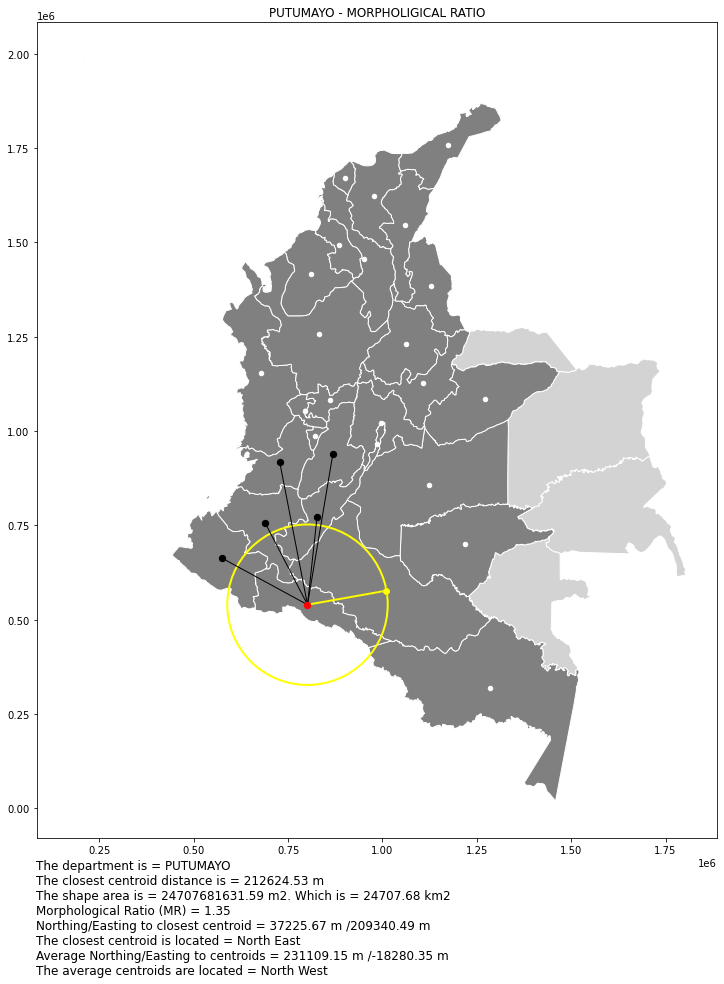

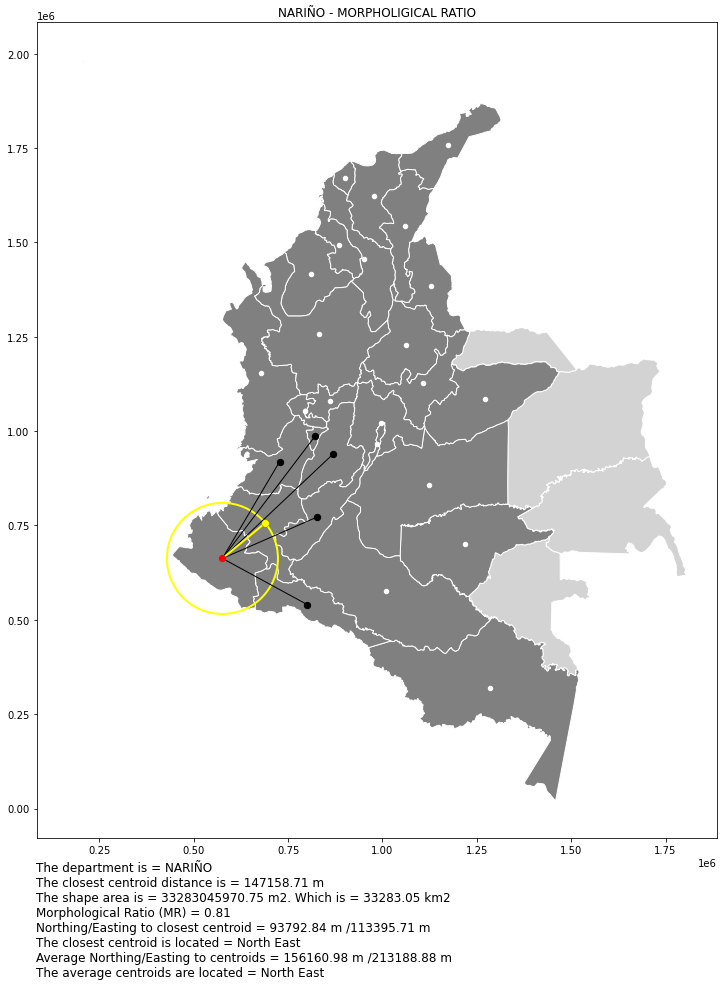

In [6]:
for department in range(geodata.shape[0]):
    morphological_ratio (7, department)

In [7]:
geodata

DPTO              DEPARTAMENTO          AREA    PERIMETER      HECTARES  \
0    91                  AMAZONAS  1.100294e+11  2562641.642  1.100294e+07   
1    95                  GUAVIARE  5.567148e+10  1555059.349  5.567148e+06   
2    85                  CASANARE  4.471409e+10  1101844.910  4.471409e+06   
3    27                     CHOCO  4.683852e+10  1797897.873  4.683852e+06   
4    88  SAN ANDRES Y PROVIDENCIA  4.960252e+07    71946.251  4.960252e+03   
5    08                 ATLANTICO  3.360765e+09   240936.172  3.360765e+05   
6    23                   CORDOBA  2.505949e+10   814093.372  2.505949e+06   
7    47                 MAGDALENA  2.284639e+10   916642.470  2.284639e+06   
8    44                   GUAJIRA  2.101235e+10   936598.020  2.101235e+06   
9    63                   QUINDIO  1.732026e+09   207948.857  1.732026e+05   
10   50                      META  8.538969e+10  1680541.812  8.538969e+06   
11   13                   BOLIVAR  2.614189e+10  1309427.968  2.614189e+06   
12   70                     SUCRE  1.082379e+10   688869.681  1.082379e+06   
13   54        NORTE DE SANTANDER  2.144333e+10   914288.244  2.144333e+06   
14   68                 SANTANDER  3.029022e+10  1036566.662  3.029022e+06   
15   17                    CALDAS  7.558200e+09   603282.457  7.558200e+05   
16   15                    BOYACA  2.335258e+10  1364539.911  2.335258e+06   
17   66                 RISARALDA  4.042733e+09   436988.677  4.042733e+05   
18   73                    TOLIMA  2.342127e+10   853045.779  2.342127e+06   
19   05                 ANTIOQUIA  6.335186e+10  1963728.843  6.335186e+06   
20   18                   CAQUETA  9.018087e+10  1888506.901  9.018087e+06   
21   25              CUNDINAMARCA  2.280026e+10  1164175.024  2.280026e+06   
22   20                     CESAR  2.297310e+10  1080343.678  2.297310e+06   
23   19                     CAUCA  2.974279e+10  1243388.952  2.974279e+06   
24   76           VALLE DEL CAUCA  2.214683e+10   995449.434  2.214683e+06   
25   41                     HUILA  2.031870e+10   929144.166  2.031870e+06   
26   11                BOGOTA D.C  1.650948e+09   323322.540  1.650948e+05   
27   86                  PUTUMAYO  2.470768e+10  1194372.666  2.470768e+06   
28   52                    NARIÑO  3.328305e+10  1015680.966  3.328305e+06   

    Cases_Frequency  Cases_Order_Value        NUMERO   ESTRATO       EDAD  \
0                 1                  0  12080.000000  2.000000  41.000000   
1                 2                  1   7904.500000  4.000000  24.000000   
2                 3                  2   8900.000000  2.666667  27.666667   
3                 6                  3  11630.500000  2.000000  38.166667   
4                 7                  4  12222.714286  2.285714  31.714286   
5                 7                  5  19200.142857  2.714286  29.714286   
6                10                  6  10559.000000  2.000000  30.500000   
7                10                  7  22336.600000  2.100000  31.600000   
8                12                  8  18769.666667  1.583333  34.583333   
9                13                  9  12444.615385  2.230769  30.230769   
10               14                 10  11956.571429  1.785714  30.357143   
11               15                 11  11511.333333  2.133333  28.933333   
12               16                 12  13343.250000  1.812500  30.562500   
13               19                 13  11872.315789  2.263158  31.157895   
14               24                 14  13715.125000  2.333333  32.250000   
15               28                 15  12134.678571  2.321429  28.678571   
16               30                 16  14923.700000  2.333333  32.266667   
17               33                 17  11852.060606  2.242424  28.909091   
18               56                 18  16966.964286  2.160714  32.642857   
19               81                 19  10171.641975  2.592593  28.864198   
20               89                 20  18349

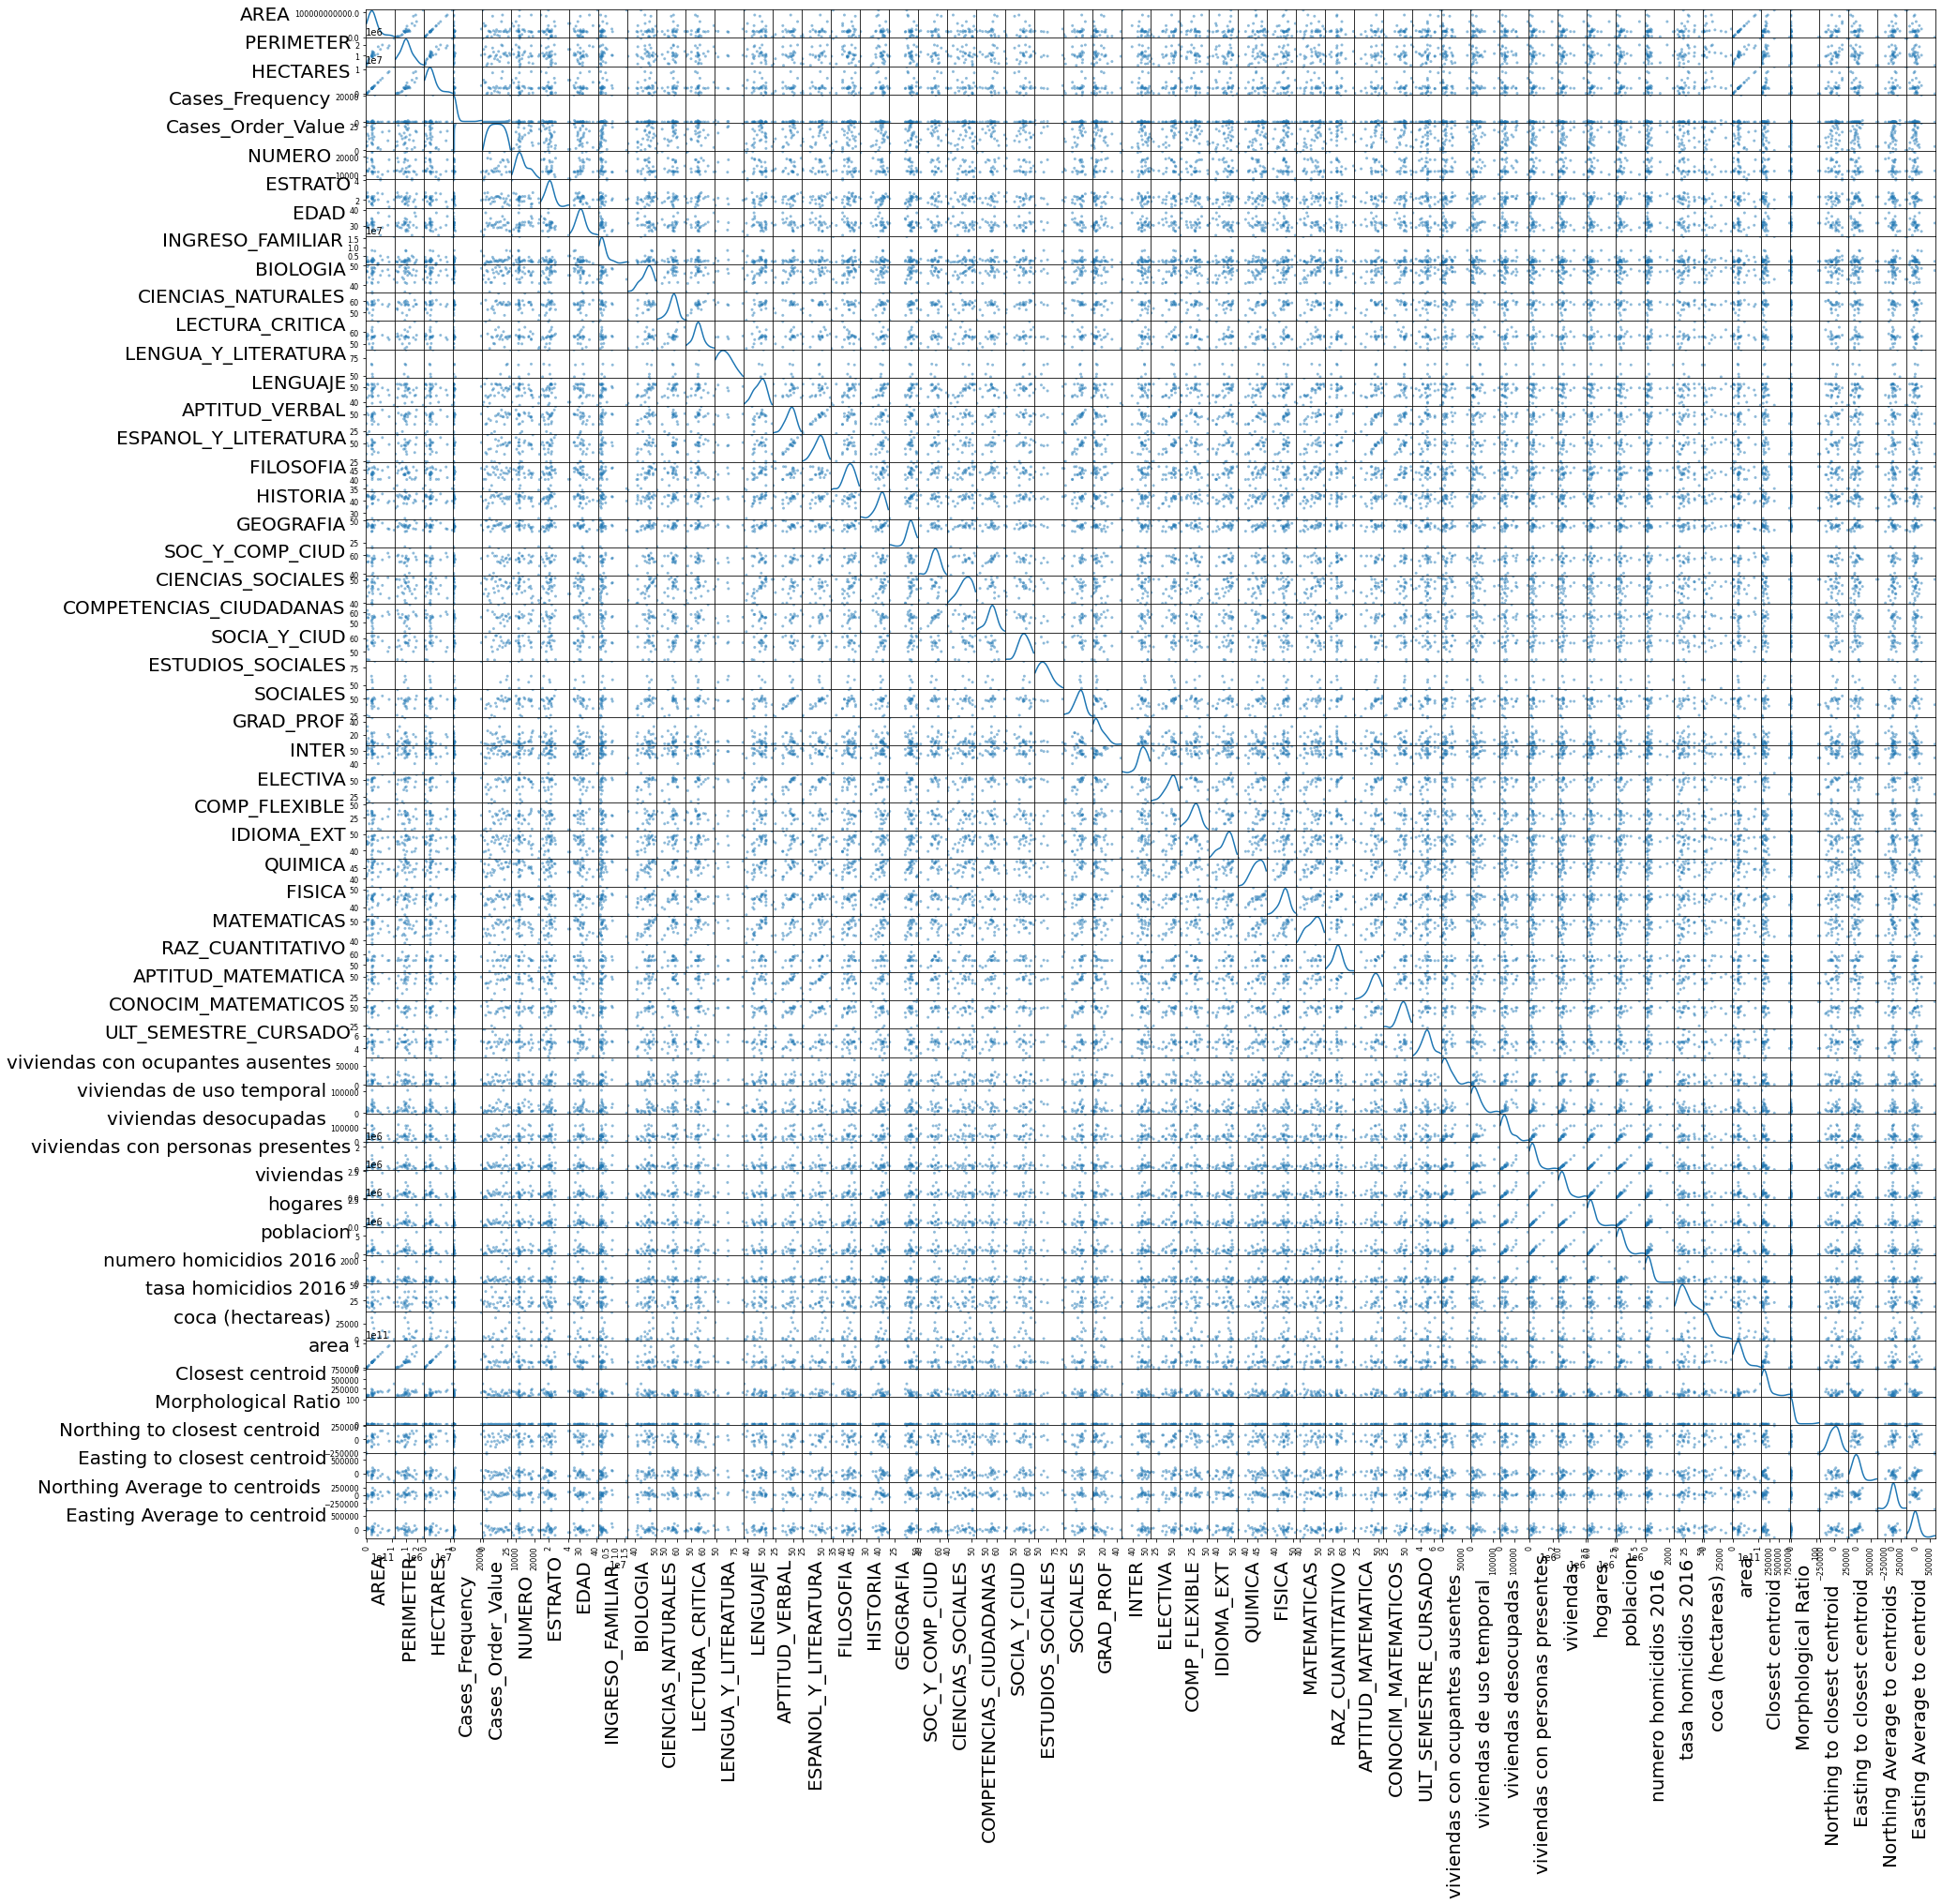

In [8]:
# Scatter matrix
scatter_matrix = pd.plotting.scatter_matrix(
    geodata,
    figsize  = [30, 30],
    # marker   = ".",
    # s        = 0.2,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 0, ha='right')
    
plt.savefig("scatter_matrix_SpaceSyntax.jpg")

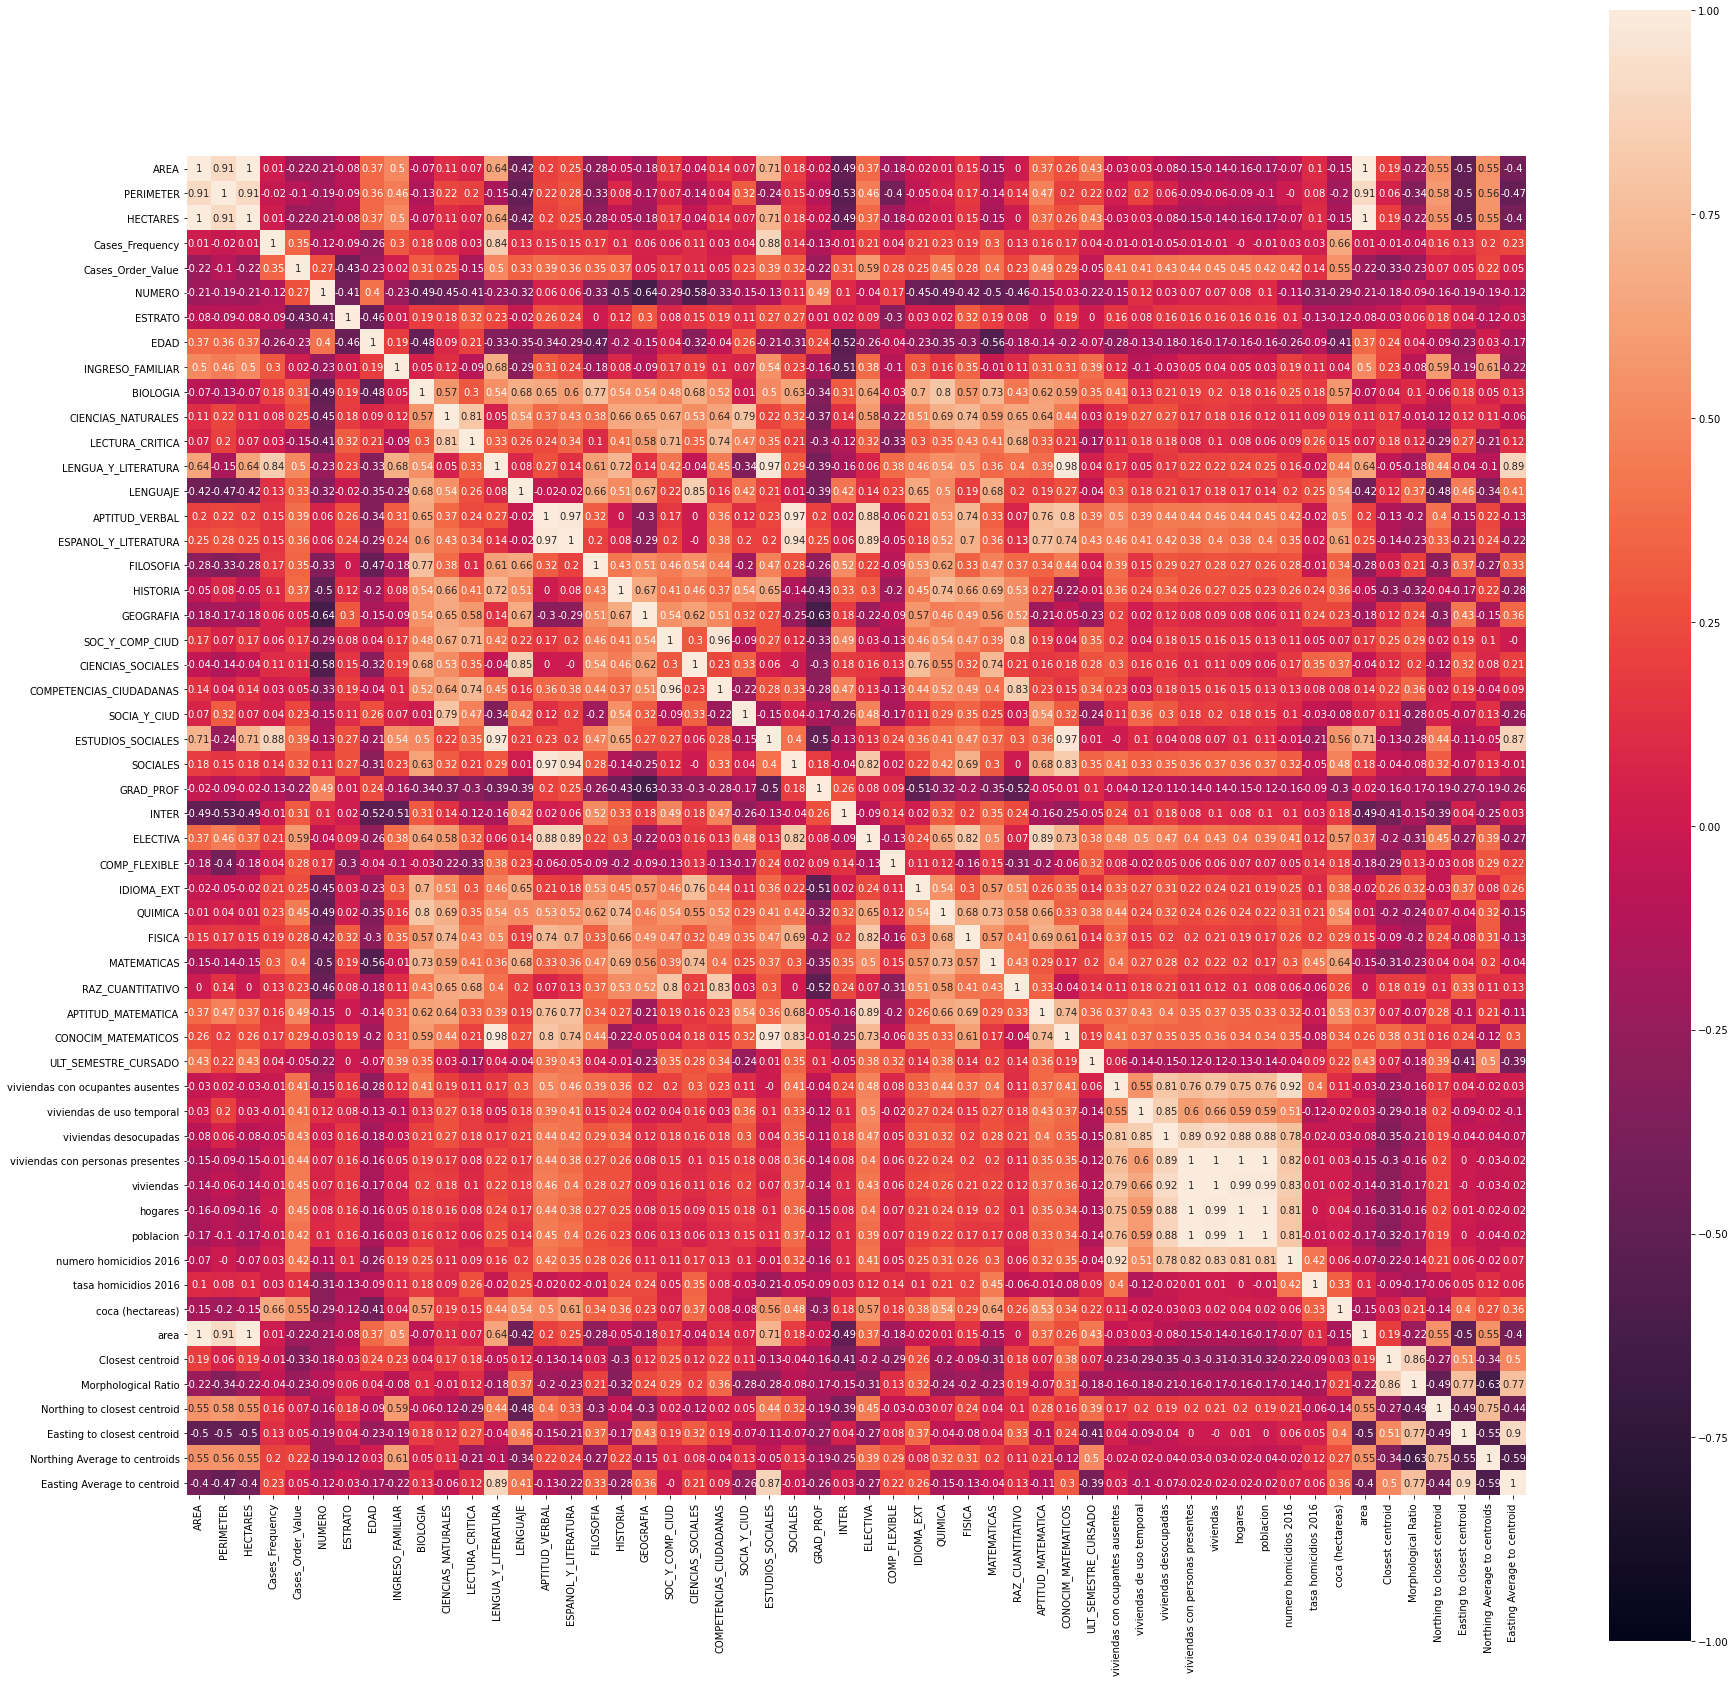

In [9]:
import seaborn as sb 

# Correlation matrix
corrMatrix = geodata.corr()

plt.rcParams['figure.figsize'] = 30, 30
data = np.round(corrMatrix, 2)
sb.heatmap(data, annot = True, vmin=-1, vmax=1, square=True) 
plt.savefig('correlation_matrix_SpaceSyntax.pdf') 

In [19]:
#Original Centroids and area column must be removed, since there should not be duplicated columns or geometry data.

geodata.drop('centroids', axis='columns', inplace=True)
geodata.drop('area', axis='columns', inplace=True)
geodata

DPTO              DEPARTAMENTO          AREA    PERIMETER      HECTARES  \
0    91                  AMAZONAS  1.100294e+11  2562641.642  1.100294e+07   
1    95                  GUAVIARE  5.567148e+10  1555059.349  5.567148e+06   
2    85                  CASANARE  4.471409e+10  1101844.910  4.471409e+06   
3    27                     CHOCO  4.683852e+10  1797897.873  4.683852e+06   
4    88  SAN ANDRES Y PROVIDENCIA  4.960252e+07    71946.251  4.960252e+03   
5    08                 ATLANTICO  3.360765e+09   240936.172  3.360765e+05   
6    23                   CORDOBA  2.505949e+10   814093.372  2.505949e+06   
7    47                 MAGDALENA  2.284639e+10   916642.470  2.284639e+06   
8    44                   GUAJIRA  2.101235e+10   936598.020  2.101235e+06   
9    63                   QUINDIO  1.732026e+09   207948.857  1.732026e+05   
10   50                      META  8.538969e+10  1680541.812  8.538969e+06   
11   13                   BOLIVAR  2.614189e+10  1309427.968  2.614189e+06   
12   70                     SUCRE  1.082379e+10   688869.681  1.082379e+06   
13   54        NORTE DE SANTANDER  2.144333e+10   914288.244  2.144333e+06   
14   68                 SANTANDER  3.029022e+10  1036566.662  3.029022e+06   
15   17                    CALDAS  7.558200e+09   603282.457  7.558200e+05   
16   15                    BOYACA  2.335258e+10  1364539.911  2.335258e+06   
17   66                 RISARALDA  4.042733e+09   436988.677  4.042733e+05   
18   73                    TOLIMA  2.342127e+10   853045.779  2.342127e+06   
19   05                 ANTIOQUIA  6.335186e+10  1963728.843  6.335186e+06   
20   18                   CAQUETA  9.018087e+10  1888506.901  9.018087e+06   
21   25              CUNDINAMARCA  2.280026e+10  1164175.024  2.280026e+06   
22   20                     CESAR  2.297310e+10  1080343.678  2.297310e+06   
23   19                     CAUCA  2.974279e+10  1243388.952  2.974279e+06   
24   76           VALLE DEL CAUCA  2.214683e+10   995449.434  2.214683e+06   
25   41                     HUILA  2.031870e+10   929144.166  2.031870e+06   
26   11                BOGOTA D.C  1.650948e+09   323322.540  1.650948e+05   
27   86                  PUTUMAYO  2.470768e+10  1194372.666  2.470768e+06   
28   52                    NARIÑO  3.328305e+10  1015680.966  3.328305e+06   

    Cases_Frequency  Cases_Order_Value        NUMERO   ESTRATO       EDAD  \
0                 1                  0  12080.000000  2.000000  41.000000   
1                 2                  1   7904.500000  4.000000  24.000000   
2                 3                  2   8900.000000  2.666667  27.666667   
3                 6                  3  11630.500000  2.000000  38.166667   
4                 7                  4  12222.714286  2.285714  31.714286   
5                 7                  5  19200.142857  2.714286  29.714286   
6                10                  6  10559.000000  2.000000  30.500000   
7                10                  7  22336.600000  2.100000  31.600000   
8                12                  8  18769.666667  1.583333  34.583333   
9                13                  9  12444.615385  2.230769  30.230769   
10               14                 10  11956.571429  1.785714  30.357143   
11               15                 11  11511.333333  2.133333  28.933333   
12               16                 12  13343.250000  1.812500  30.562500   
13               19                 13  11872.315789  2.263158  31.157895   
14               24                 14  13715.125000  2.333333  32.250000   
15               28                 15  12134.678571  2.321429  28.678571   
16               30                 16  14923.700000  2.333333  32.266667   
17               33                 17  11852.060606  2.242424  28.909091   
18               56                 18  16966.964286  2.160714  32.642857   
19               81                 19  10171.641975  2.592593  28.864198   
20               89                 20  18349

In [20]:
geodata.to_file("geodata-spacesyntax.gpkg", driver="GPKG")